# Chapter 6: Multiple Linear Regression - Solution

> (c) 2019 Galit Shmueli, Peter C. Bruce, Peter Gedeck 
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition) 
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.

In [1]:
# !pip install dmba

In [2]:
import dmba

no display found. Using non-interactive Agg backend


In [3]:
# import required functionality for this chapter



import matplotlib as mlt
%matplotlib inline
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as sm
import matplotlib.pylab as plt
# sometimes matplotlib chooses an x-using backend by default. 
plt.switch_backend('agg') 
mlt.use('agg')
import seaborn as sns

from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score
%matplotlib inline

In [4]:
# working directory
# We assume that data are kept in the same directory as the notebook. If you keep your data in a different folder, replace the 
# argument of the `Path`
# DATA = Path('./data')
# and then load data using 
DATA = pd.read_csv("./data/BostonHousing.csv") 

# Problem 6.1 Predicting Bostom Housing Prices 

The file _BostonHousing.csv_ contains information collected by the US Bureau of the Census concerning housing in the area of
Boston, Massachusetts. The dataset includes information on 506 census housing tracts in the Boston area. The goal is to predict the median house price in new tracts based on information such as crime rate, pollution, and number of rooms. The dataset contains 13 predictors, and the outcome variable is the median house price (MEDV). Table 6.11 describes each of the predictors and the outcome variable.

![TABLE_6.11](TABLE6.11.PNG)


In [5]:
y = DATA['MEDV']
X = DATA.drop(columns=['MEDV'])


In [6]:
len(X.columns)

13

In [7]:
# Your answer here
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)



__6.1.a.__ Why should the data be partitioned into training and validation sets? What will the training set be used for? What will the validation set be used for?

__Answer:__ 

train data로는 머신 러닝 모델 작성을, validation data로는 머신러닝 모델에 대한 평가를 진행해야함.  
때문에 model작업 전 데이터 셋을 분리해두어 train과정과 test과정이 서로 독립적으로 수행될 수 있도록 함.

__6.1.b.__ Fit a multiple linear regression model to the median house price (MEDV) as a function of CRIM, CHAS, and RM. Write the equation for predicting the median house price from the predictors in the model.

__Answer:__


In [8]:
# Your answer here

predict_col = ['CRIM', 'CHAS', 'RM']
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

model = lr.fit(X_train[predict_col], y_train)
result = model.predict(X_test[predict_col])

__6.1.c.__ Using the estimated regression model, what median house price is predicted for a tract in the Boston area that does not bound the Charles River, has a crime rate of 0.1, and where the average number of rooms per house is 6?

__Answer:__ 

In [9]:
# Your answer here
# CHAS >> 0 
# CRIM >> 0.1
# RM >> 6
model.predict([[0.1, 0, 6]])

array([20.72346535])

__6.1.d.i.__ Reduce the number of predictors:
Which predictors are likely to be measuring the same thing among the 13 predictors? Discuss the relationships among INDUS, NOX, and TAX.

__Answer:__ 

In [10]:
# Your answer here
X_train.corr().loc[['INDUS', 'NOX', 'TAX'], ['INDUS', 'NOX', 'TAX']]

,INDUS,NOX,TAX
INDUS,1.000000,0.770957,0.702353
NOX,0.770957,1.000000,0.650247
TAX,0.702353,0.650247,1.000000


세 변수가 서로 어느정도의 상관관계를 가지고 있어 이는 보스톤이 non-retail 비즈니스가 성행함에 따라 높은 세율과 오염이 진행되었다고 해석할 수 있다.

__6.1.d.ii.__ Compute the correlation table for the 11 numerical predictors and search for highly correlated pairs. These have potential redundancy and can cause multicollinearity. Choose which ones to remove based on this table.

__Answer:__

In [11]:
# Your answer here
df_corr = X_train.corr()

In [12]:
def onetozero(x):
#     print(x)
    return np.where(x==1, 0, x)

In [13]:
df_corr = df_corr.apply(lambda x: onetozero(x))

In [14]:
df_corr.shape

(13, 13)

In [15]:
print(df_corr.max().sort_values(ascending=False).index[0])
print(df_corr[df_corr.max().sort_values(ascending=False).index[0]].idxmax())

RAD
TAX


In [16]:
print(df_corr.max().sort_values(ascending=False).index[1])
print(df_corr[df_corr.max().sort_values(ascending=False).index[1]].idxmax())

TAX
RAD


In [17]:
print(df_corr.max().sort_values(ascending=False).index[2])
print(df_corr[df_corr.max().sort_values(ascending=False).index[2]].idxmax())

INDUS
NOX


__6.1.d.iii.__ Use stepwise regression with the three options (backward, forward, both) to reduce the remaining predictors as follows: Run stepwise on the training set. Choose the top model from each stepwise run. Then use each of these models separately to predict the validation set. Compare RMSE, MAPE, and mean error, as well as lift charts. Finally, describe the best model.

__Answer:__

In [18]:
# Your answer here

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
import statsmodels.formula.api as sm 
import matplotlib.pylab as plt
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection 
from dmba import adjusted_r2_score, AIC_score, BIC_score
from dmba import liftChart, gainsChart


In [19]:
def train_model(variables):
    model = LinearRegression() 
    model.fit(X_train[variables], y_train) 
    return model

def score_model(model, variables):
    return AIC_score(y_train, model.predict(X_train[variables]), model)

allVariables = X_train.columns
backward_best_model, backward_best_variables = backward_elimination(allVariables, train_model,score_model, verbose=True) 
regressionSummary(y_test, backward_best_model.predict(X_test[backward_best_variables]))

Variables: CRIM, ZN, INDUS, CHAS, NOX, RM, AGE, DIS, RAD, TAX, PTRATIO, LSTAT, CAT. MEDV
Start: score=2219.72
Step: score=2219.28, remove AGE
Step: score=2219.28, remove None

Regression statistics

                      Mean Error (ME) : 0.3417
       Root Mean Squared Error (RMSE) : 3.8180
            Mean Absolute Error (MAE) : 2.6696
          Mean Percentage Error (MPE) : -0.8003
Mean Absolute Percentage Error (MAPE) : 13.5194


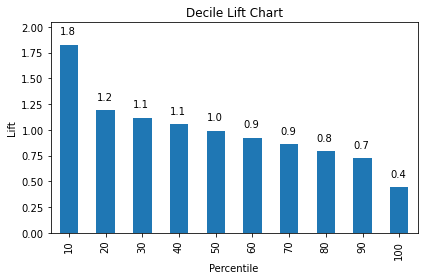

In [20]:
pred_v = pd.Series(backward_best_model.predict(X_test[backward_best_variables])) 
pred_v = pred_v.sort_values(ascending=False)

ax = liftChart(pred_v) 
ax.set_ylabel('Lift')
plt.tight_layout() 
plt.show()
     

In [21]:
def train_model(variables):
    if len(variables) == 0: 
        return None
    model = LinearRegression() 
    model.fit(X_train[variables], y_train) 
    return model

def score_model(model, variables): 
    if len(variables) == 0:
        return AIC_score(y_train, [y_train.mean()] * len(y_train), model, df=1)
    return AIC_score(y_train, model.predict(X_train[variables]), model)

foward_best_model, foward_best_variables = forward_selection(X_train.columns, train_model,score_model, verbose=True)
regressionSummary(y_test, foward_best_model.predict(X_test[foward_best_variables]))


Variables: CRIM, ZN, INDUS, CHAS, NOX, RM, AGE, DIS, RAD, TAX, PTRATIO, LSTAT, CAT. MEDV
Start: score=2954.14, constant
Step: score=2551.24, add CAT. MEDV
Step: score=2310.80, add LSTAT
Step: score=2288.72, add CRIM
Step: score=2273.27, add DIS
Step: score=2262.55, add PTRATIO
Step: score=2250.04, add NOX
Step: score=2236.90, add CHAS
Step: score=2227.06, add RM
Step: score=2223.91, add ZN
Step: score=2221.86, add INDUS
Step: score=2221.71, add RAD
Step: score=2219.28, add TAX
Step: score=2219.28, add None

Regression statistics

                      Mean Error (ME) : 0.3417
       Root Mean Squared Error (RMSE) : 3.8180
            Mean Absolute Error (MAE) : 2.6696
          Mean Percentage Error (MPE) : -0.8003
Mean Absolute Percentage Error (MAPE) : 13.5194


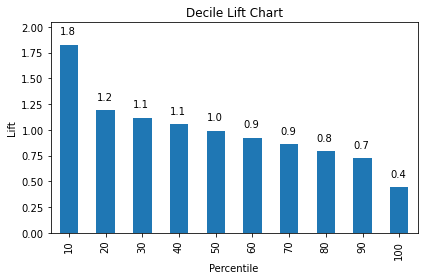

In [22]:
pred_v = pd.Series(foward_best_model.predict(X_test[foward_best_variables])) 
pred_v = pred_v.sort_values(ascending=False)

ax = liftChart(pred_v) 
ax.set_ylabel('Lift')
plt.tight_layout() 
plt.show()
     

In [23]:
stepwise_best_model, stepwise_best_variables = stepwise_selection(X_train.columns, train_model,score_model, verbose=True)
regressionSummary(y_test, stepwise_best_model.predict(X_test[stepwise_best_variables]))

Variables: CRIM, ZN, INDUS, CHAS, NOX, RM, AGE, DIS, RAD, TAX, PTRATIO, LSTAT, CAT. MEDV
Start: score=2954.14, constant
Step: score=2551.24, add CAT. MEDV
Step: score=2310.80, add LSTAT
Step: score=2288.72, add CRIM
Step: score=2273.27, add DIS
Step: score=2262.55, add PTRATIO
Step: score=2250.04, add NOX
Step: score=2236.90, add CHAS
Step: score=2227.06, add RM
Step: score=2223.91, add ZN
Step: score=2221.86, add INDUS
Step: score=2221.71, add RAD
Step: score=2219.28, add TAX
Step: score=2219.28, unchanged None

Regression statistics

                      Mean Error (ME) : 0.3417
       Root Mean Squared Error (RMSE) : 3.8180
            Mean Absolute Error (MAE) : 2.6696
          Mean Percentage Error (MPE) : -0.8003
Mean Absolute Percentage Error (MAPE) : 13.5194


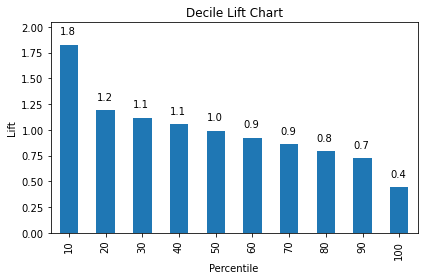

In [24]:
pred_v = pd.Series(stepwise_best_model.predict(X_test[stepwise_best_variables])) 
pred_v = pred_v.sort_values(ascending=False)

ax = liftChart(pred_v) 
ax.set_ylabel('Lift')
plt.tight_layout() 
plt.show()
     